In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torch.nn import functional as F
import torchvision

import numpy as np
import torchutils as tu

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

In [2]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

Dataset URL: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign
License(s): unknown
skin-cancer-malignant-vs-benign.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip skin-cancer-malignant-vs-benign.zip

Archive:  skin-cancer-malignant-vs-benign.zip
replace data/test/benign/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [10]:
trnsfrms = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor(),
        T.RandomResizedCrop(224, scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation(degrees=30),
        T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        T.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    ]
)

In [11]:
train_dataset = torchvision.datasets.ImageFolder(
    'train',
    transform=trnsfrms
)
valid_dataset = torchvision.datasets.ImageFolder(
    'test',
    transform=T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor(),]
))

In [12]:
DEVICE = 'cuda'
BATCH_SIZE = 512
fake_batch = torch.randn(4, 3, 224, 224, device=DEVICE)

In [13]:
from torchvision.models import resnet152, ResNet152_Weights

In [17]:
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet152(weights=ResNet152_Weights.DEFAULT)
        self.model.fc = nn.Linear(2048, 1)
        for i in self.model.parameters():
            i.requires_grad = False
        self.model.fc.weight.requires_grad = True
        self.model.fc.bias.requires_grad = True

    def forward(self, x):
        x = self.model(x)
        return torch.sigmoid(x)

In [14]:
idx2class= {j: i for i, j in train_dataset.class_to_idx.items()}

In [15]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
model = MyResNet()

In [19]:
model.to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
def plot_history(history, grid=True):
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    
    ax[0].plot(history['train_losses'], label='train loss')
    ax[0].plot(history['valid_losses'], label='valid loss')
    ax[0].set_title(f'Loss on epoch {len(history["train_losses"])}')
    ax[0].grid(grid)
    ax[0].legend()
    
    ax[1].plot(history['train_accs'], label='train acc')
    ax[1].plot(history['valid_accs'], label='valid acc')
    ax[1].set_title(f'Accuracy on epoch {len(history["train_losses"])}')
    ax[1].grid(grid)
    ax[1].legend()
    
    plt.show()

In [18]:
def fit_model(
        model: nn.Module, 
        epochs: int, 
        optimizer: torch.optim.Optimizer, 
        history = None
        ) -> dict:
    '''
    model: pytorch model - model to train
    epochs: int          - number of epochs
    plot_every: int      - plot every N iterations
    '''
    
    # будем сохранять значения точности и лосса в history
    history = history or {
        'train_accs': [],
        'train_losses': [],
        'valid_accs': [],
        'valid_losses': [],
    }

    # определяем текущую эпоху обучения
    start_epoch = len(history['train_accs'])
    for epoch in range(start_epoch+1, start_epoch+epochs+1):
        print(f'{"-"*13} Epoch {epoch} {"-"*13}')

        model.train()
        batch_accs = []
        batch_losses = [] 
        for samples, labels in train_loader: 
            
            samples = samples.to(DEVICE)
            labels = labels.view(-1, 1).float().to(DEVICE)
            
            y_pred = model(samples)
            
            # Считаем лосс: передаем в функцию потерь предсказания и 
            # настоящие метки классов
            # иногда надо переводить между long() и float(), 
            # об этом pytorch предупредит

            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            # print(f'Predictions: {y_pred}')
            # сравниваем предсказания с таргетом и добавляем в 
            # список значение точности
            # BATCH_SIZE x N_CLASSES = 64 X 10 -> argmax -> 64 x 1

            batch_accs.append((y_pred.round() == labels).cpu().numpy().mean())

        history['train_losses'].append(np.mean(batch_losses))
        history['train_accs'].append(np.mean(batch_accs))

        # Validation
        model.eval()
    
        batch_accs = []
        batch_losses = []
        for samples, labels in valid_loader:
            with torch.no_grad():
                y_pred = model(samples.to(DEVICE))
            labels = labels.view(-1, 1).float().to(DEVICE)
            loss = criterion(y_pred, labels.to(DEVICE))
            batch_losses.append(loss.item())
            batch_accs.append((y_pred.round() == labels).cpu().numpy().mean())
        history['valid_accs'].append(np.mean(batch_accs))
        history['valid_losses'].append(np.mean(batch_losses))
        
        
        # печатаем результат
        
        print(
            f'train: accuracy {history["train_accs"][-1]:.4f}, loss {history["train_losses"][-1]:.4f}\n'
            f'valid: accuracy {history["valid_accs"][-1]:.4f}, loss {history["valid_losses"][-1]:.4f}'
        )
        print(f'{"-"*35}')
        print()
    
    # печатаем графики
    plot_history(history)

    return history

In [20]:
tu.get_model_summary(model, fake_batch)
torch.cuda.empty_cache()

Layer                                               Kernel              Output          Params           FLOPs
0_model.Conv2d_conv1                               [3, 64, 7, 7]   [4, 64, 112, 112]       9,408   472,055,808
1_model.BatchNorm2d_bn1                                     [64]   [4, 64, 112, 112]         128    12,845,056
2_model.ReLU_relu                                              -   [4, 64, 112, 112]           0             0
3_model.MaxPool2d_maxpool                                      -     [4, 64, 56, 56]           0             0
4_model.layer1.0.Conv2d_conv1                     [64, 64, 1, 1]     [4, 64, 56, 56]       4,096    51,380,224
5_model.layer1.0.BatchNorm2d_bn1                            [64]     [4, 64, 56, 56]         128     3,211,264
6_model.layer1.0.ReLU_relu                                     -     [4, 64, 56, 56]           0             0
7_model.layer1.0.Conv2d_conv2                     [64, 64, 3, 3]     [4, 64, 56, 56]      36,864   462,422,016
8

------------- Epoch 1 -------------
train: accuracy 0.6207, loss 0.6500
valid: accuracy 0.6098, loss 0.6599
-----------------------------------

------------- Epoch 2 -------------
train: accuracy 0.7621, loss 0.5807
valid: accuracy 0.7247, loss 0.5959
-----------------------------------

------------- Epoch 3 -------------
train: accuracy 0.8003, loss 0.5306
valid: accuracy 0.7612, loss 0.5453
-----------------------------------

------------- Epoch 4 -------------
train: accuracy 0.7973, loss 0.4966
valid: accuracy 0.7535, loss 0.5230
-----------------------------------

------------- Epoch 5 -------------
train: accuracy 0.8030, loss 0.4701
valid: accuracy 0.7889, loss 0.4918
-----------------------------------

------------- Epoch 6 -------------
train: accuracy 0.8200, loss 0.4439
valid: accuracy 0.8063, loss 0.4634
-----------------------------------

------------- Epoch 7 -------------
train: accuracy 0.8100, loss 0.4378
valid: accuracy 0.8314, loss 0.4472
----------------------

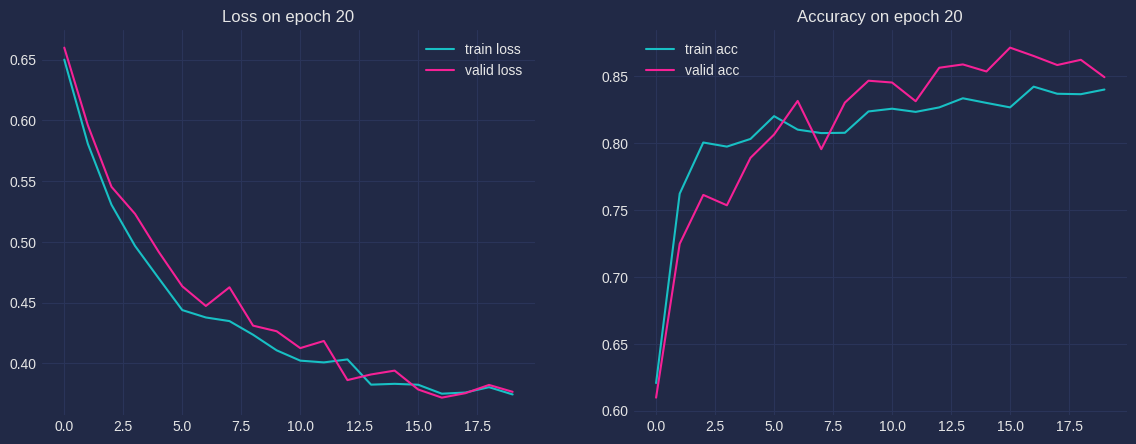

In [21]:
logs = fit_model(model, 20, optimizer)

In [19]:
class MyResNet_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet152(weights=ResNet152_Weights.DEFAULT)
        self.model.fc = nn.Linear(2048, 1)
        for i in self.model.parameters():
            i.requires_grad = False

        for param in self.model.layer4.parameters():
            param.requires_grad = True

        for param in self.model.fc.parameters():
            param.requires_grad = True
        
    def forward(self, x):
        x = self.model(x)
        return torch.sigmoid(x)

In [20]:
model_2 = MyResNet_2()
model_2.to(DEVICE)
torch.cuda.empty_cache()

In [21]:
tu.get_model_summary(model_2, fake_batch)
torch.cuda.empty_cache()

Layer                                               Kernel              Output          Params           FLOPs
0_model.Conv2d_conv1                               [3, 64, 7, 7]   [4, 64, 112, 112]       9,408   472,055,808
1_model.BatchNorm2d_bn1                                     [64]   [4, 64, 112, 112]         128    12,845,056
2_model.ReLU_relu                                              -   [4, 64, 112, 112]           0             0
3_model.MaxPool2d_maxpool                                      -     [4, 64, 56, 56]           0             0
4_model.layer1.0.Conv2d_conv1                     [64, 64, 1, 1]     [4, 64, 56, 56]       4,096    51,380,224
5_model.layer1.0.BatchNorm2d_bn1                            [64]     [4, 64, 56, 56]         128     3,211,264
6_model.layer1.0.ReLU_relu                                     -     [4, 64, 56, 56]           0             0
7_model.layer1.0.Conv2d_conv2                     [64, 64, 3, 3]     [4, 64, 56, 56]      36,864   462,422,016
8

In [22]:
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)
criterion = nn.BCELoss()

------------- Epoch 1 -------------
train: accuracy 0.7738, loss 0.4513
valid: accuracy 0.6247, loss 1.9507
-----------------------------------

------------- Epoch 2 -------------
train: accuracy 0.8913, loss 0.2619
valid: accuracy 0.8275, loss 1.6405
-----------------------------------

------------- Epoch 3 -------------
train: accuracy 0.8990, loss 0.2338
valid: accuracy 0.8035, loss 4.0689
-----------------------------------

------------- Epoch 4 -------------
train: accuracy 0.9087, loss 0.2062
valid: accuracy 0.8147, loss 0.6079
-----------------------------------

------------- Epoch 5 -------------
train: accuracy 0.9150, loss 0.1848
valid: accuracy 0.8062, loss 0.5192
-----------------------------------

------------- Epoch 6 -------------
train: accuracy 0.9281, loss 0.1670
valid: accuracy 0.8523, loss 0.3916
-----------------------------------

------------- Epoch 7 -------------
train: accuracy 0.9362, loss 0.1448
valid: accuracy 0.8268, loss 0.6107
----------------------

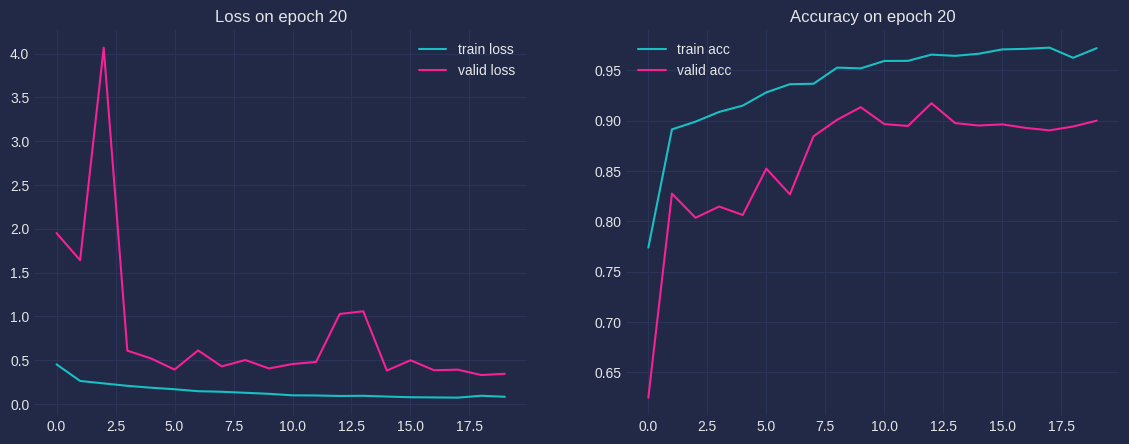

In [23]:
logs_new = fit_model(model_2, 20, optimizer)

In [22]:
results = {
    'fine_tune' : logs,
    'unfreeze' : logs_new
}

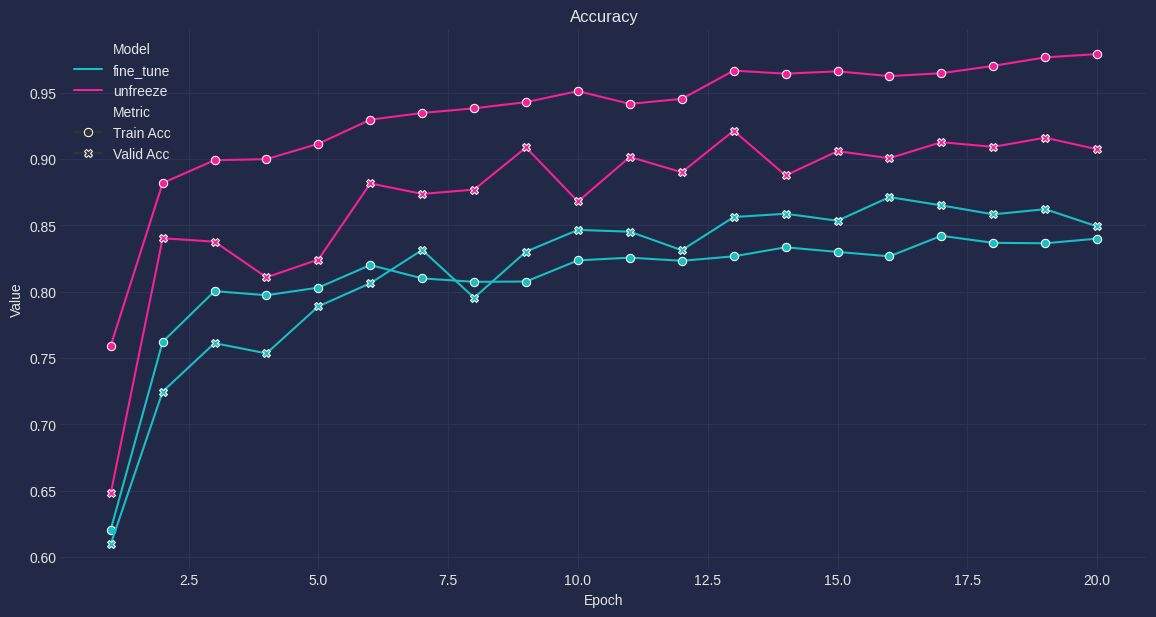

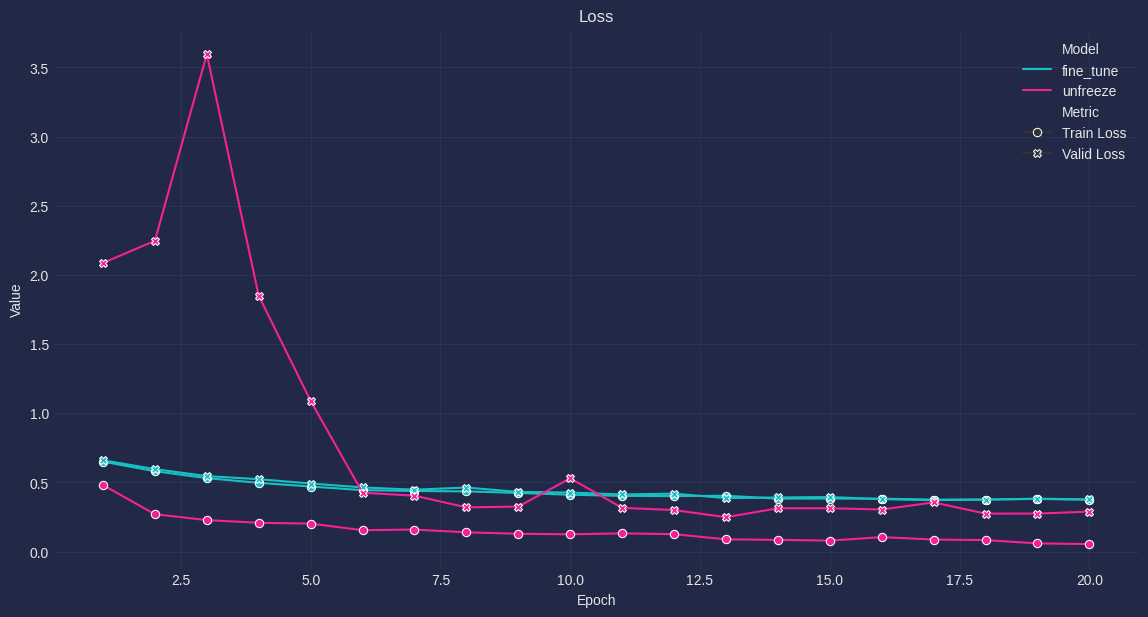

In [23]:
def prepare_data(data, metric):
    rows = []
    for model, values in data.items():
        train_key = f'train_{metric}es' if metric == 'loss' else f'train_{metric}s'
        valid_key = f'valid_{metric}es' if metric == 'loss' else f'valid_{metric}s'
        for i, (train_val, valid_val) in enumerate(zip(values[train_key], values[valid_key])):
            rows.append({'Epoch': i+1, 'Value': train_val, 'Metric': f'Train {metric.capitalize()}', 'Model': model})
            rows.append({'Epoch': i+1, 'Value': valid_val, 'Metric': f'Valid {metric.capitalize()}', 'Model': model})
    return pd.DataFrame(rows)

acc_data = prepare_data(results, 'acc')
loss_data = prepare_data(results, 'loss')

plt.figure(figsize=(14, 7))
sns.lineplot(x='Epoch', y='Value', hue='Model', style='Metric', data=acc_data, markers=True, dashes=False)
plt.title('Accuracy')

plt.figure(figsize=(14, 7))
sns.lineplot(x='Epoch', y='Value', hue='Model', style='Metric', data=loss_data, markers=True, dashes=False)
plt.title('Loss');

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

batch_precisions = []
batch_accs = []
batch_recalls = []
all_labels = []
all_preds = []


for samples, labels in valid_loader:
    with torch.no_grad():
        y_pred = model_2(samples.to(DEVICE))
    labels = labels.view(-1, 1).float().to(DEVICE)
    batch_accs.append((y_pred.round() == labels).cpu().numpy().mean())
    
    true_positives = ((y_pred.round() == 1) & (labels == 1)).sum().item()
    false_negatives = ((y_pred.round() == 0) & (labels == 1)).sum().item()
    false_positives = ((y_pred.round() == 1) & (labels == 0)).sum().item()
    
    recall = true_positives / (true_positives + false_negatives)
    precision = true_positives / (true_positives + false_positives)
    
    batch_precisions.append(precision)
    batch_recalls.append(recall)
    
    all_labels.append(labels.cpu().numpy())
    all_preds.append(y_pred.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

roc_auc = roc_auc_score(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)

print(f'acc: {np.mean(batch_accs)}')
print(f'recall: {np.mean(batch_recalls)}')
print(f'precisions: {np.mean(batch_precisions)}')
print(f'ROC AUC: {roc_auc}')

acc: 0.9119774070945945
recall: 0.8887825878976321
precisions: 0.9167887862376554
ROC AUC: 0.9629444444444446


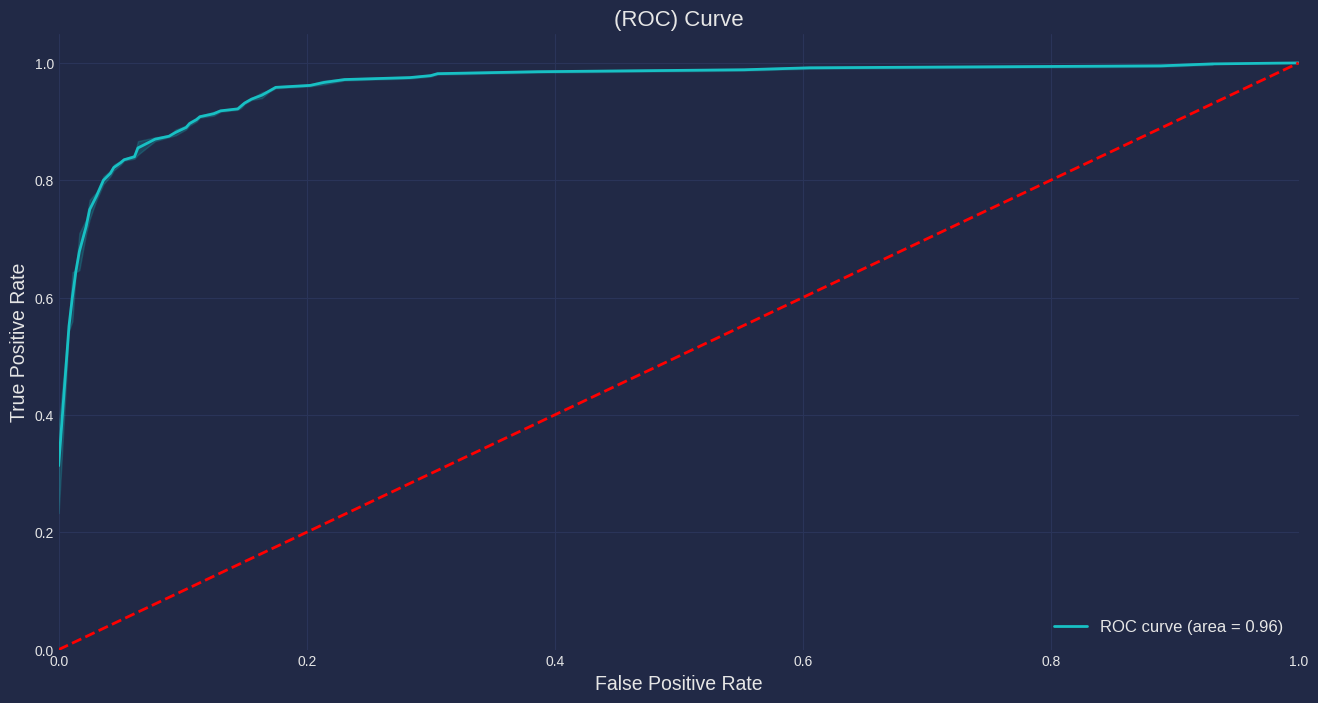

In [25]:
plt.figure(figsize=(16, 8))
sns.lineplot(x=fpr, y=tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
sns.lineplot(x=[0, 1], y=[0, 1], color='red', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('(ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)

In [27]:
from sklearn.metrics import fbeta_score

beta = 3

roc_auc = roc_auc_score(all_labels, all_preds)
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)

fbeta_scores = []
for threshold in thresholds:
    # Бинаризуем предсказания на основе текущего порога
    y_pred_binary = (all_preds >= threshold).astype(int)
    fbeta = fbeta_score(all_labels, y_pred_binary, beta=beta)
    fbeta_scores.append(fbeta)

# Находим индекс порога с максимальной F-бета мерой
best_threshold_index = np.argmax(fbeta_scores)
optimal_threshold = thresholds[best_threshold_index]

print(f'Optimal threshold for maximum F-beta score (beta={beta}): {optimal_threshold}')
print(f'Maximum F-beta score: {fbeta_scores[best_threshold_index]}')

Optimal threshold for maximum F-beta score (beta=3): 0.001721094478853047
Maximum F-beta score: 0.9500805152979066


In [28]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score

batch_precisions = []
batch_accs = []
batch_recalls = []
all_labels = []
all_preds = []

for samples, labels in valid_loader:
    with torch.no_grad():
        y_pred = model_2(samples.to(DEVICE))
    labels = labels.view(-1, 1).float().to(DEVICE)
    
    all_labels.append(labels.cpu().numpy())
    all_preds.append(y_pred.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

preds_binary = (all_preds >= optimal_threshold).astype(int)

precision = precision_score(all_labels, preds_binary)
recall = recall_score(all_labels, preds_binary)
accuracy = accuracy_score(all_labels, preds_binary)
roc_auc = roc_auc_score(all_labels, all_preds)

print(f'Accuracy at optimal threshold: {accuracy}')
print(f'Recall at optimal threshold: {recall}')
print(f'Precision at optimal threshold: {precision}')
print(f'ROC AUC: {roc_auc}')

Accuracy at optimal threshold: 0.8242424242424242
Recall at optimal threshold: 0.98
Precision at optimal threshold: 0.7277227722772277
ROC AUC: 0.962962962962963


In [35]:
def round_by_threshold(value):
    return 1 if value >= optimal_threshold else 0

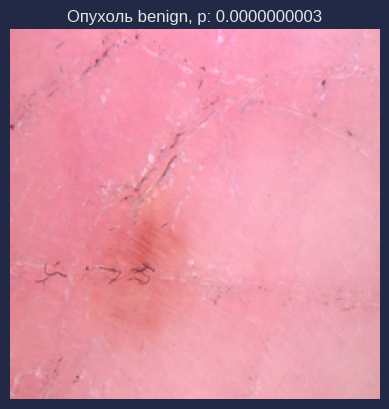

In [47]:
from torchvision import io

transform = T.Compose([
        T.Resize((224, 224)),
    ])

image_path = 'test/benign/1006.jpg'


img = io.read_image(image_path)
img = transform(img) / 255
plt.imshow(torch.permute(img, (1, 2, 0)))
with torch.inference_mode():
    pred_prob = model_2(img.unsqueeze(0).to(DEVICE)).item()
    pred_class = round_by_threshold(pred_prob)
plt.axis('off')
plt.title(f'Опухоль {idx2class[pred_class]}, p: {pred_prob:.10f}');

In [42]:
torch.save(model_2.state_dict(), 'model_kudinov.pt')

In [49]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(all_labels, preds_binary)

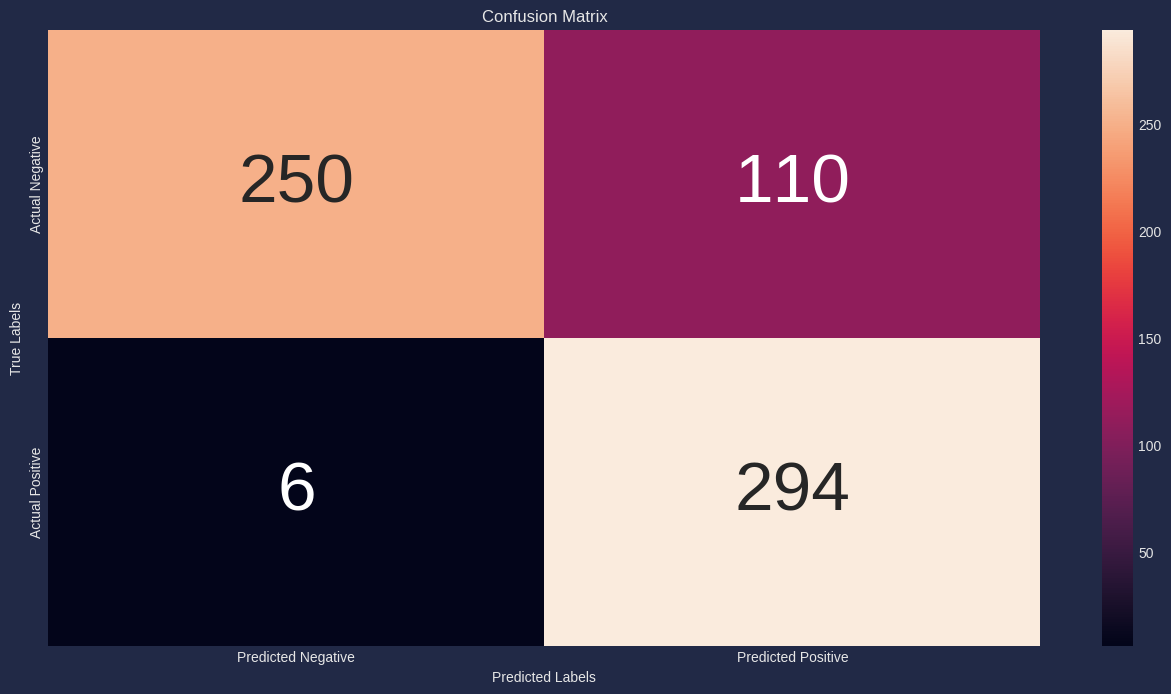

In [59]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

plt.figure(figsize=(16, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'], annot_kws={"size": 50})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix');

In [60]:
preds_binary = (all_preds >= 0.5).astype(int)

In [61]:
conf_matrix = confusion_matrix(all_labels, preds_binary)

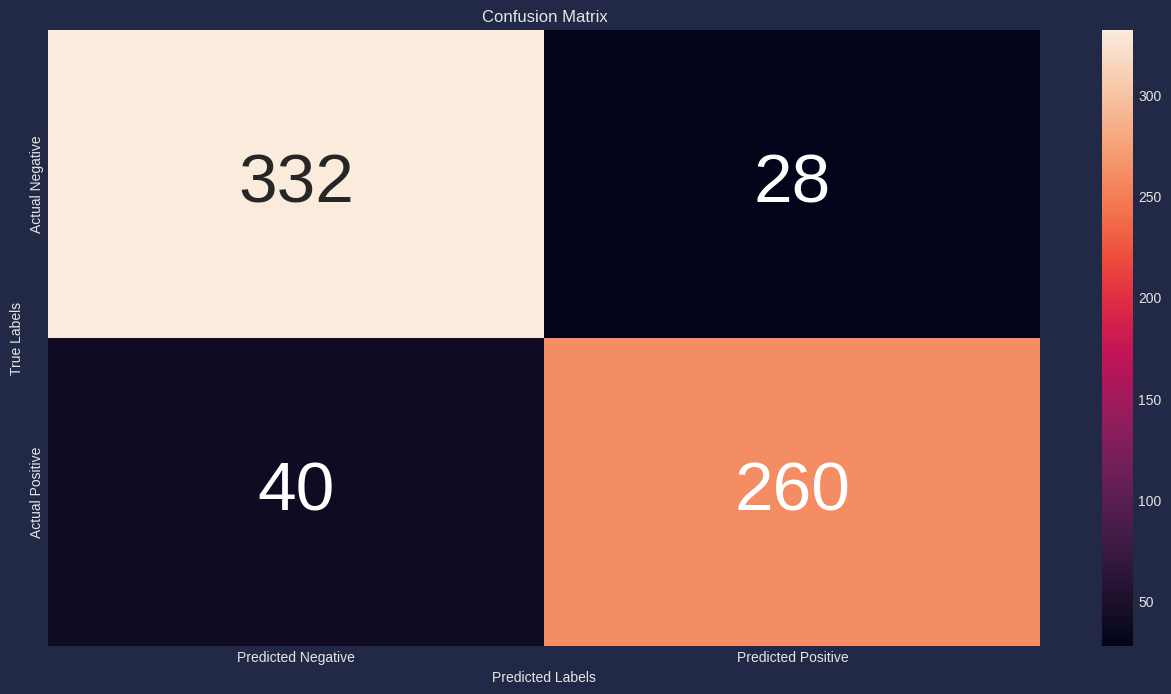

In [63]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

plt.figure(figsize=(16, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'], annot_kws={"size": 50})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix');